In [3]:
import grass.script as gs
import pandas as pd
import os

# -------------------------
# PARAMETERS & CLASS SETUP
# -------------------------

# Update this for your pixel resolution (assumed 300m here)
PIXEL_AREA_KM2 = 0.09  

# Class labels and color mapping
class_labels = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# Years to process
periods = [("1992", "2000"), ("2000", "2010"), ("2010", "2020")]

# Unique prefix to avoid name conflicts
unique_prefix = "lc_transition_analysis"

# Create output directory
os.makedirs("transition_outputs", exist_ok=True)

# -------------------------
# TRANSITION MATRIX FUNCTION
# -------------------------

def compute_transition_matrix(year_start, year_end):
    raster1 = f"clipped_land_cover_{year_start}"
    raster2 = f"clipped_land_cover_{year_end}"
    transition_map = f"{unique_prefix}_{year_start}_{year_end}"

    print(f"\nProcessing transition: {year_start} → {year_end}")

    # Set region
    gs.run_command("g.region", raster=raster1)

    # Compute transition map
    gs.mapcalc(f"{transition_map} = {raster1} * 1000 + {raster2}", overwrite=True)

    # Get pixel transitions
    stats = gs.read_command("r.stats", flags="cn", input=transition_map, sep=":")
    if not stats.strip():
        print(f"No transitions found between {raster1} and {raster2}")
        return None

    data = []
    for line in stats.strip().splitlines():
        code, count = line.split(":")
        combined = int(code)
        from_class = combined // 1000
        to_class = combined % 1000

        if from_class in class_labels and to_class in class_labels:
            data.append({
                "From": from_class,
                "To": to_class,
                "Count": int(count),
                "Area_km2": int(count) * PIXEL_AREA_KM2,
                "Period": f"{year_start}-{year_end}"
            })

    # Save to CSV
    df = pd.DataFrame(data)
    output_file = f"transition_outputs/{unique_prefix}_matrix_{year_start}_{year_end}.csv"
    df.to_csv(output_file, index=False)
    print(f"✔ Saved CSV: {output_file}")
    return df

# -------------------------
# CREATE TRANSITION MAP (2000–2010)
# -------------------------

def generate_transition_map_visual(year_start="2000", year_end="2010"):
    r1 = f"clipped_land_cover_{year_start}"
    r2 = f"clipped_land_cover_{year_end}"
    map_name = f"{unique_prefix}_map_{year_start}_{year_end}"

    print(f"\nGenerating transition map: {map_name}")
    gs.run_command("g.region", raster=r1)
    gs.mapcalc(f"{map_name} = {r1} * 1000 + {r2}", overwrite=True)

    # Get unique transitions
    stats = gs.read_command("r.stats", flags="n", input=map_name)
    transitions = [int(val) for val in stats.strip().splitlines() if val.strip().isdigit()]

    # Assign unique color to each transition
    color_file = f"/tmp/{map_name}_colors.txt"
    with open(color_file, "w") as f:
        for i, code in enumerate(sorted(transitions)):
            r = (i * 47) % 255
            g = (i * 89) % 255
            b = (i * 131) % 255
            f.write(f"{code} {r}:{g}:{b}\n")

    gs.run_command("r.colors", map=map_name, rules=color_file)
    print(f"✔ Transition map created: {map_name}")

    return map_name

# -------------------------
# RUN ALL TRANSITIONS
# -------------------------

all_dfs = []
for y1, y2 in periods:
    df = compute_transition_matrix(y1, y2)
    if df is not None:
        all_dfs.append(df)

# Optional: Combine all for a master CSV
if all_dfs:
    combined_df = pd.concat(all_dfs)
    combined_df.to_csv(f"transition_outputs/{unique_prefix}_matrix_ALL.csv", index=False)
    print(f"✔ Combined matrix saved: {unique_prefix}_matrix_ALL.csv")

# -------------------------
# MAP FOR 2000–2010
# -------------------------
generate_transition_map_visual("2000", "2010")





Processing transition: 1992 → 2000


✔ Saved CSV: transition_outputs/lc_transition_analysis_matrix_1992_2000.csv

Processing transition: 2000 → 2010


✔ Saved CSV: transition_outputs/lc_transition_analysis_matrix_2000_2010.csv

Processing transition: 2010 → 2020


✔ Saved CSV: transition_outputs/lc_transition_analysis_matrix_2010_2020.csv
✔ Combined matrix saved: lc_transition_analysis_matrix_ALL.csv

Generating transition map: lc_transition_analysis_map_2000_2010
✔ Transition map created: lc_transition_analysis_map_2000_2010



Color table for raster map <lc_transition_analysis_map_2000_2010> set to
'/tmp/lc_transition_analysis_map_2000_2010_colors.txt'


'lc_transition_analysis_map_2000_2010'

In [5]:
import pandas as pd
import os

# Path to the folder containing the CSVs
csv_folder = 'transition_outputs/'

# List of CSV files to load
csv_files = [
    'lc_transition_analysis_matrix_1992_2000.csv',
    'lc_transition_analysis_matrix_2000_2010.csv',
    'lc_transition_analysis_matrix_2010_2020.csv'
]

# Dictionary to hold DataFrames for each time period
transition_dfs = {}

# Load each CSV as a DataFrame
for file in csv_files:
    file_path = os.path.join(csv_folder, file)
    period = file.replace('lc_transition_analysis_matrix_', '').replace('.csv', '')
    df = pd.read_csv(file_path, index_col=0)
    transition_dfs[period] = df
    print(f"\n📊 Transition Matrix: {period}")
    display(df)



📊 Transition Matrix: 1992_2000


,To,Count,Area_km2,Period
From,,,,
5,5,131,11.79,1992-2000
5,20,1,0.09,1992-2000
7,7,1438,129.42,1992-2000
7,20,3,0.27,1992-2000
8,8,24816,2233.44,1992-2000
8,13,69,6.21,1992-2000
8,20,106,9.54,1992-2000
9,9,3,0.27,1992-2000
12,12,374,33.66,1992-2000



📊 Transition Matrix: 2000_2010


,To,Count,Area_km2,Period
From,,,,
5,5,129,11.61,2000-2010
5,20,3,0.27,2000-2010
7,7,1582,142.38,2000-2010
7,20,17,1.53,2000-2010
8,8,25329,2279.61,2000-2010
8,13,191,17.19,2000-2010
8,20,656,59.04,2000-2010
9,9,3,0.27,2000-2010
12,12,231,20.79,2000-2010



📊 Transition Matrix: 2010_2020


,To,Count,Area_km2,Period
From,,,,
5,5,129,11.61,2010-2020
7,7,1623,146.07,2010-2020
7,20,1,0.09,2010-2020
8,8,25721,2314.89,2010-2020
8,13,107,9.63,2010-2020
8,20,140,12.60,2010-2020
9,9,3,0.27,2010-2020
12,12,200,18.00,2010-2020
12,13,31,2.79,2010-2020



Color table for raster map <lc_transition_analysis_1992_2000> set to
'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
</var/folders/mz/wk_rk1fs2m96vphdr62m5bym0000gn/T/grass8-ghulamabbaszafari-10859/tmp5jq1nkuj/temp_raster.tif>
created.


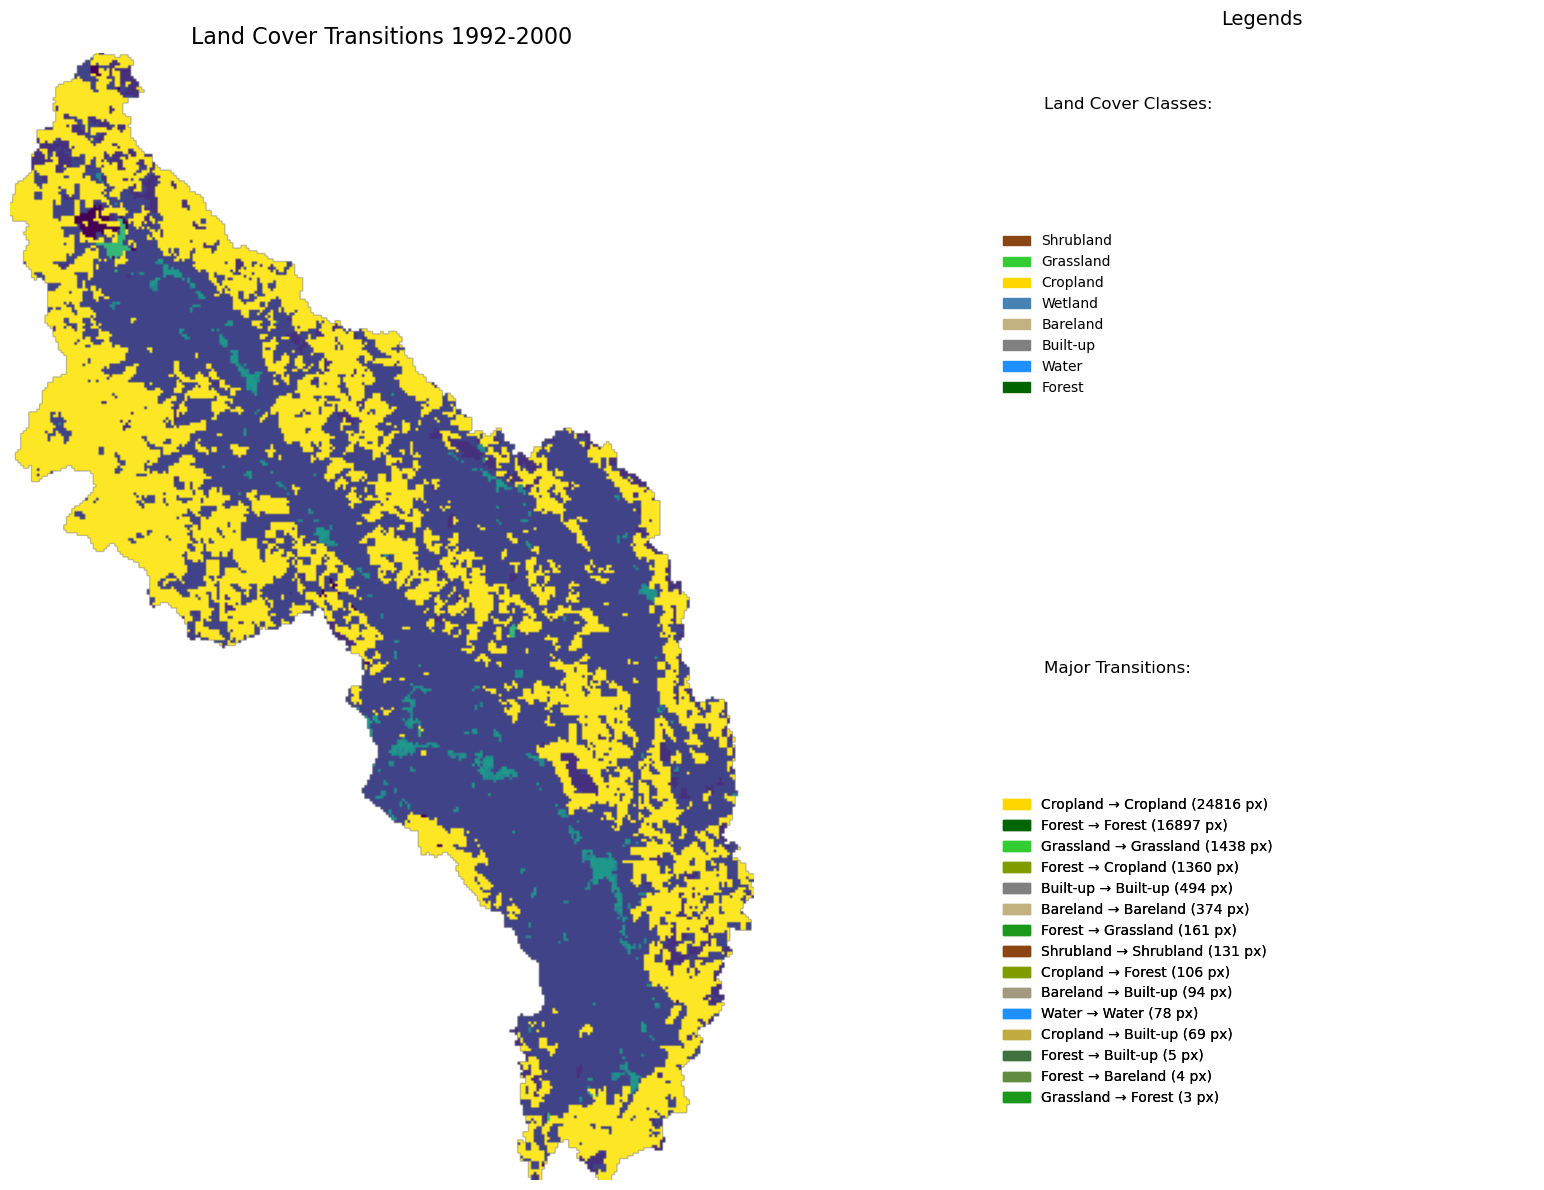

In [23]:
import os
import sys
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import grass.script as gs
import grass.script.setup as gsetup
import rasterio
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec

# Setup GRASS environment
gisbase = '/Applications/GRASS-8.4.app/Contents/Resources'
gisdb = '/Users/ghulamabbaszafari/grassdata'
location = 'my_location'
mapset = 'PERMANENT'

os.environ['GISBASE'] = gisbase
os.environ['GISDBASE'] = gisdb
os.environ['LOCATION_NAME'] = location
os.environ['MAPSET'] = mapset
sys.path.append(os.path.join(gisbase, 'etc', 'python'))
gsetup.init(gisdb, location, mapset)

# Transition map to visualize
raster_map = 'lc_transition_analysis_1992_2000'

# Land cover class definitions
CLASS_LABELS = {
    5: 'Shrubland',
    7: 'Grassland',
    8: 'Cropland',
    9: 'Wetland',
    11: 'Lichens and mosses',
    12: 'Bareland',
    13: 'Built-up',
    15: 'Water',
    16: 'Permanent ice and Snow',
    20: 'Forest',
    255: 'No data'
}

# Color map with your specified colors
COLOR_MAP = {
    5: '#8b4513',    # Shrubland (SaddleBrown)
    7: '#32cd32',    # Grassland (LimeGreen)
    8: '#ffd700',    # Cropland (Gold)
    9: '#4682b4',    # Wetland (SteelBlue)
    11: '#a9cda9',   # Lichens and mosses (LightGreen)
    12: '#c2b280',   # Bareland (Khaki)
    13: '#808080',   # Built-up (Gray)
    15: '#1e90ff',   # Water (DodgerBlue)
    16: '#b0c4de',   # Permanent ice and Snow (LightSteelBlue)
    20: '#006400',   # Forest (DarkGreen)
    255: '#ffffff'   # No data (White)
}

def visualize_transition_map():
    """Visualize transition map with class colors and transition legend"""
    # Reset any existing color table
    gs.run_command('r.colors', map=raster_map, flags='r')
    
    # Get all unique transition codes and their counts
    stats = gs.read_command("r.stats", flags="cn", input=raster_map, sep=":")
    transitions = []
    for line in stats.strip().splitlines():
        if ':' in line:
            code, count = line.split(":")
            transitions.append((int(code), int(count)))
    
    # Sort transitions by count (descending)
    transitions.sort(key=lambda x: x[1], reverse=True)
    
    # Create color rules and legend entries
    color_rules = []
    class_legend_entries = set()
    transition_legend_entries = []
    
    for code, count in transitions:
        from_class = code // 1000
        to_class = code % 1000
        
        # Add to class legend
        if to_class in COLOR_MAP and to_class in CLASS_LABELS:
            class_legend_entries.add((to_class, CLASS_LABELS[to_class], COLOR_MAP[to_class]))
        
        # Create blended color for transitions (mix of from and to colors)
        if from_class in COLOR_MAP and to_class in COLOR_MAP:
            from_color = COLOR_MAP[from_class]
            to_color = COLOR_MAP[to_class]
            
            # Simple blending - average of RGB values
            if from_color.startswith('#') and to_color.startswith('#'):
                r = (int(from_color[1:3], 16) + int(to_color[1:3], 16)) // 2
                g = (int(from_color[3:5], 16) + int(to_color[3:5], 16)) // 2
                b = (int(from_color[5:7], 16) + int(to_color[5:7], 16)) // 2
                blended_color = f"#{r:02x}{g:02x}{b:02x}"
                color_rules.append(f"{code} {blended_color}")
                
                # Add to transition legend (top 15 transitions)
                if len(transition_legend_entries) < 15:
                    from_label = CLASS_LABELS.get(from_class, f"Class {from_class}")
                    to_label = CLASS_LABELS.get(to_class, f"Class {to_class}")
                    transition_legend_entries.append((f"{from_label} → {to_label}", blended_color, count))
    
    # Apply color rules to the raster
    if color_rules:
        gs.write_command("r.colors", map=raster_map, rules="-", stdin="\n".join(color_rules))
    
    # Export and display the raster
    with tempfile.TemporaryDirectory() as tmpdirname:
        temp_tif = os.path.join(tmpdirname, 'temp_raster.tif')
        gs.run_command('r.out.gdal', input=raster_map, output=temp_tif, format='GTiff', overwrite=True)
        
        with rasterio.open(temp_tif) as src:
            raster_array = src.read(1)
            nodata = src.nodata
            raster_masked = np.ma.masked_equal(raster_array, nodata)
            
            # Create figure with custom grid layout
            fig = plt.figure(figsize=(20, 12))
            gs_fig = GridSpec(1, 2, width_ratios=[3, 1])
            
            # Map plot
            ax1 = fig.add_subplot(gs_fig[0])
            im = ax1.imshow(raster_masked, cmap='viridis')  # Actual colors come from GRASS
            ax1.set_title('Land Cover Transitions 1992-2000', fontsize=16)
            ax1.axis('off')
            
            # Legend area
            ax2 = fig.add_subplot(gs_fig[1])
            ax2.axis('off')
            
            # Create class legend
            class_patches = [Patch(color=color, label=label) 
                           for (class_val, label, color) in sorted(class_legend_entries, key=lambda x: x[0])]
            
            # Create transition legend
            trans_patches = [Patch(color=color, label=f"{label} ({count} px)") 
                           for (label, color, count) in transition_legend_entries]
            
            # Add legends to the plot
            ax2.set_title('Legends', fontsize=14, pad=20)
            
            # Class legend
            ax2.text(0.1, 0.95, 'Land Cover Classes:', fontsize=12, transform=ax2.transAxes)
            class_legend = ax2.legend(handles=class_patches, loc='upper left', 
                                    bbox_to_anchor=(0, 0.85), frameon=False, fontsize=10)
            
            # Transition legend
            ax2.text(0.1, 0.45, 'Major Transitions:', fontsize=12, transform=ax2.transAxes)
            trans_legend = ax2.legend(handles=trans_patches, loc='upper left', 
                                    bbox_to_anchor=(0, 0.35), frameon=False, fontsize=10)
            
            # Manually add the legends to the axes
            ax2.add_artist(class_legend)
            ax2.add_artist(trans_legend)
            
            plt.tight_layout()
            plt.show()

# Run the visualization
visualize_transition_map()





Color table for raster map <lc_transition_analysis_1992_2000> set to
'rules'
Checking GDAL data type and nodata value...

Using GDAL data type <UInt16>
Input raster map contains cells with NULL-value (no-data). The value 65535
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...

r.out.gdal complete. File
</var/folders/mz/wk_rk1fs2m96vphdr62m5bym0000gn/T/grass8-ghulamabbaszafari-10859/tmp0o3wrt3b/temp_raster.tif>
created.


✔ Ultra HD plot saved to: transition_maps/lc_transition_analysis_1992_2000_ultraHD.png


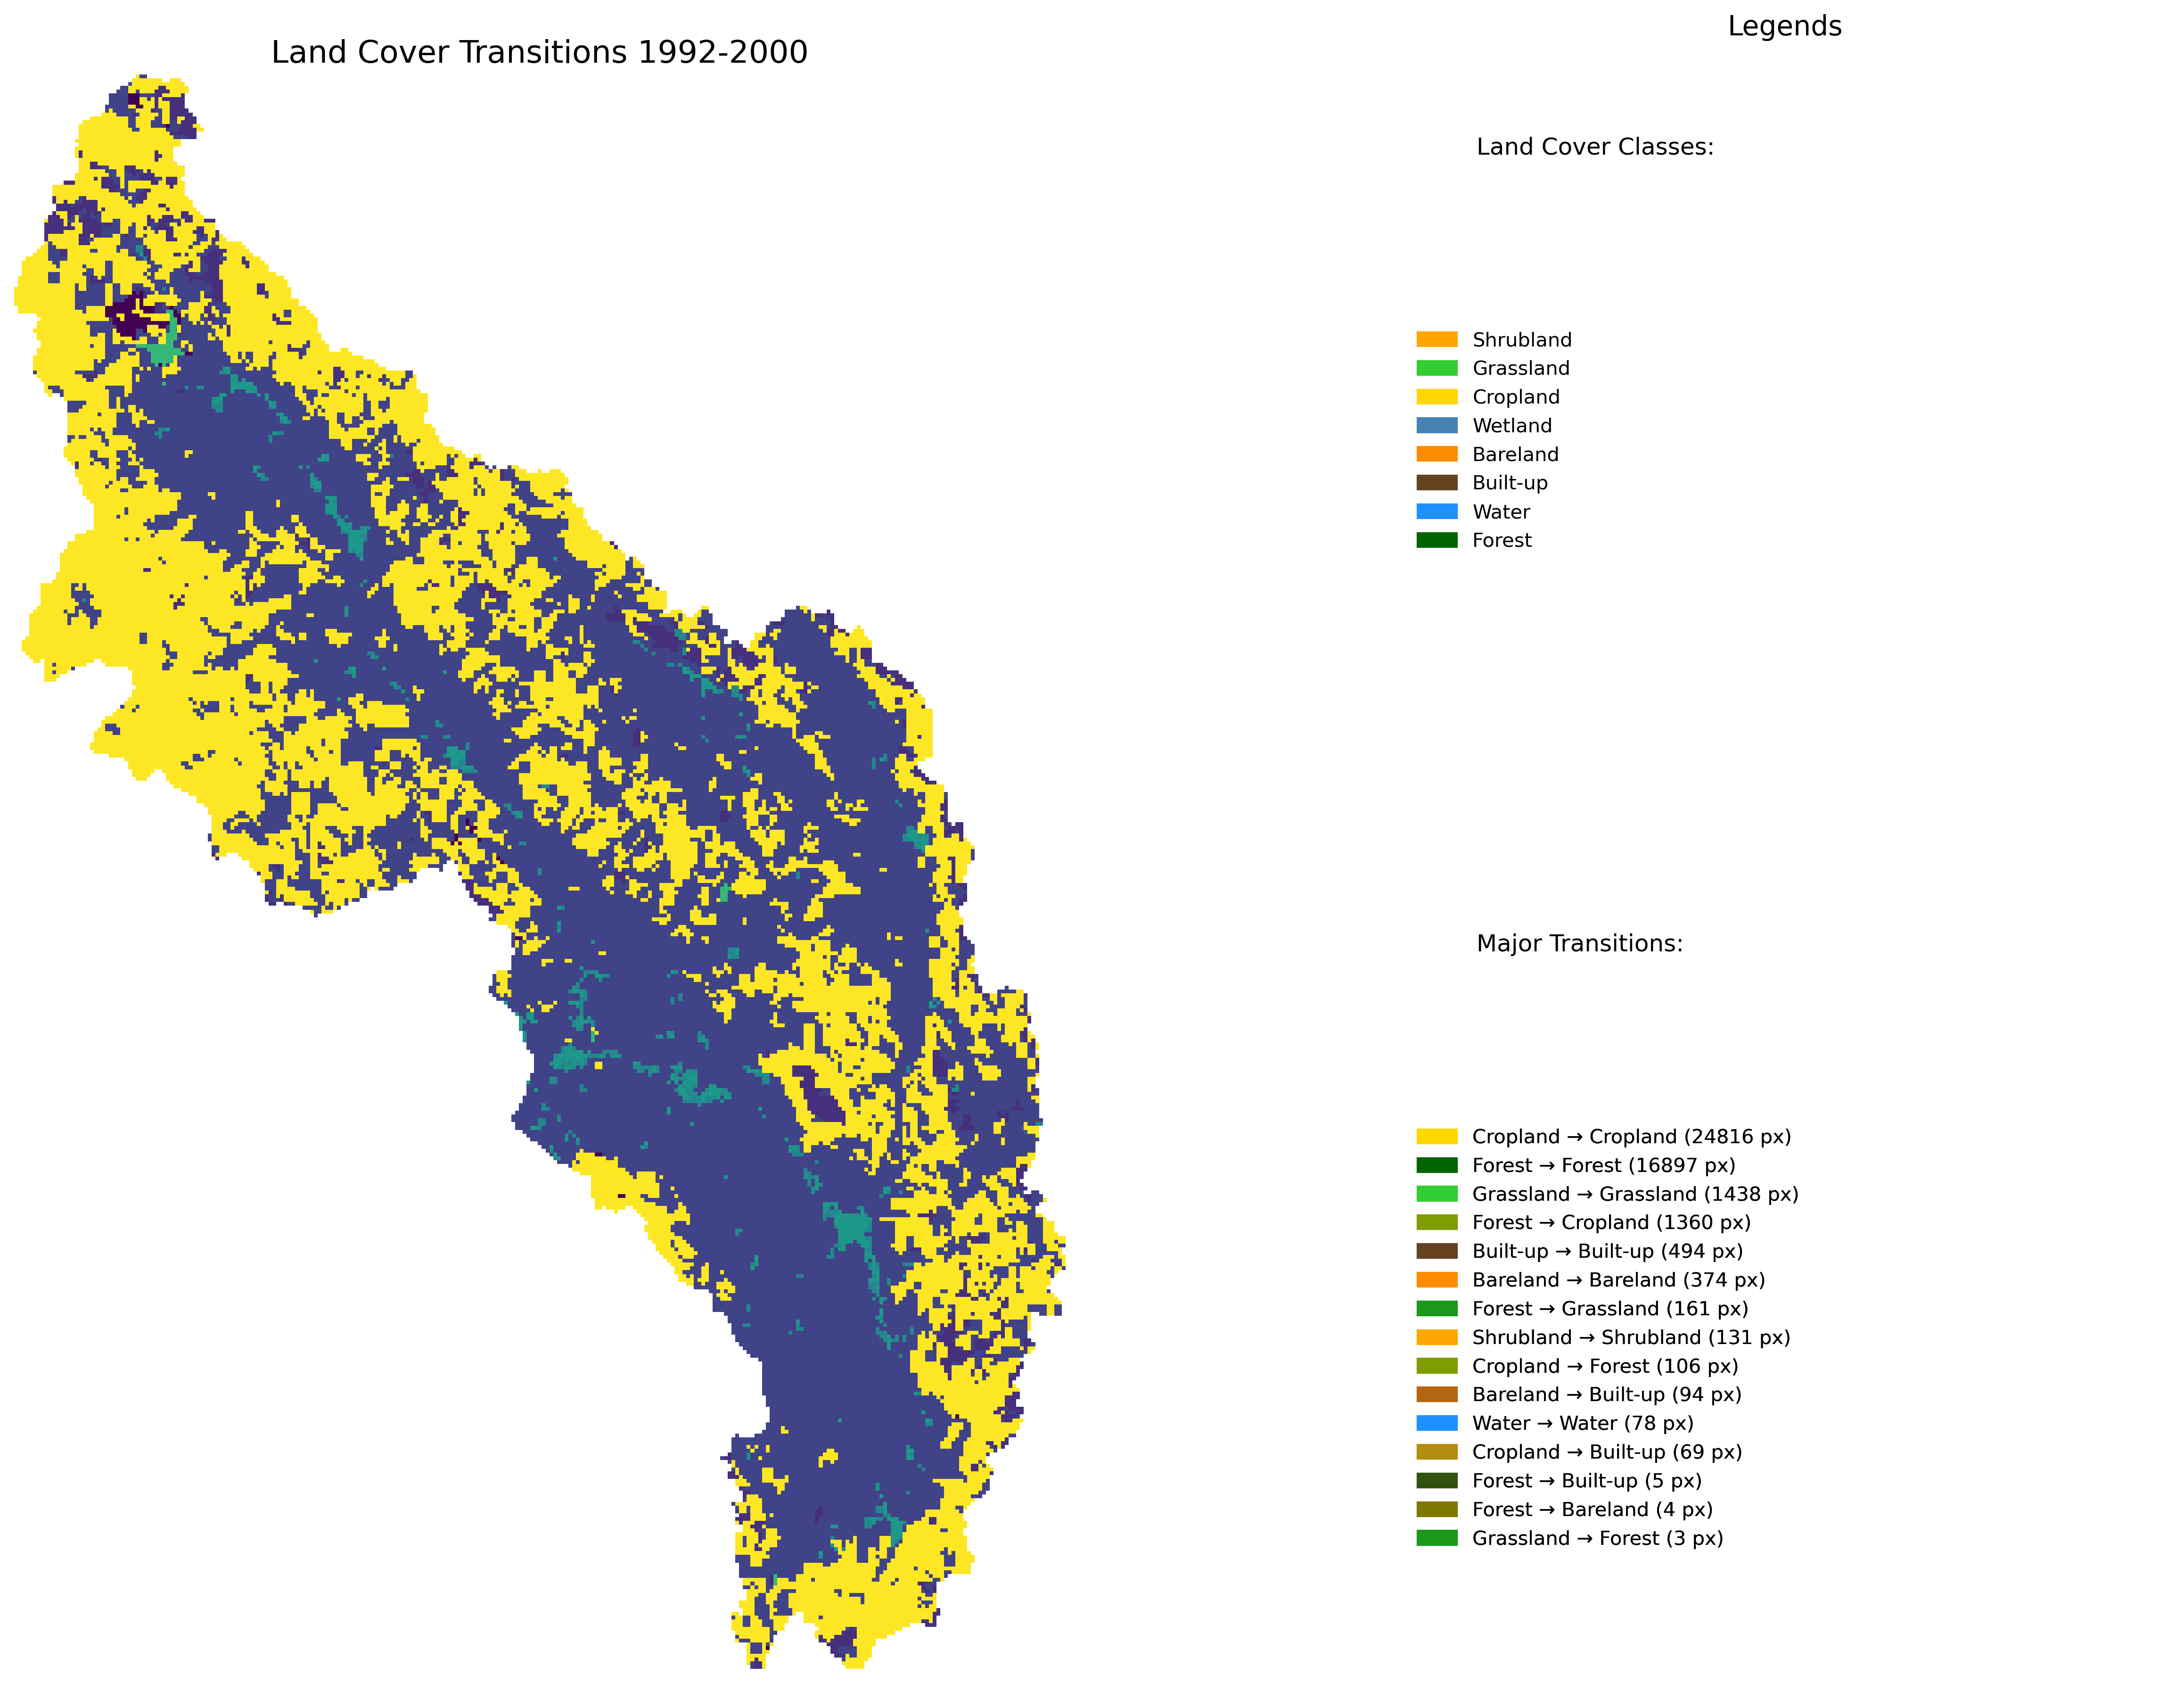

In [28]:
import os
import sys
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import grass.script as gs
import grass.script.setup as gsetup
import rasterio
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec

# Setup GRASS environment
gisbase = '/Applications/GRASS-8.4.app/Contents/Resources'
gisdb = '/Users/ghulamabbaszafari/grassdata'
location = 'my_location'
mapset = 'PERMANENT'

os.environ['GISBASE'] = gisbase
os.environ['GISDBASE'] = gisdb
os.environ['LOCATION_NAME'] = location
os.environ['MAPSET'] = mapset
sys.path.append(os.path.join(gisbase, 'etc', 'python'))
gsetup.init(gisdb, location, mapset)

# Transition map to visualize
raster_map = 'lc_transition_analysis_1992_2000'

# Class definitions
CLASS_LABELS = {
    5: "Shrubland",
    7: "Grassland",
    8: "Cropland",
    9: "Wetland",
    11: "Lichens and mosses",
    12: "Bareland",
    13: "Built-up",
    15: "Water",
    16: "Permanent ice and Snow",
    20: "Forest",
    255: "No data"
}

# Color mapping with your specified colors
COLOR_MAP = {
    5: '#FFA500',        # Shrubland (bright orange/brown)
    7: '#32cd32',        # Grassland (LimeGreen)
    8: '#ffd700',        # Cropland (Gold)
    9: '#4682b4',        # Wetland (SteelBlue)
    11: '#a9cda9',       # Lichens and mosses (LightGreen)
    12: '#FF8C00',       # Bareland (DarkOrange)
    13: '#654321',       # Built-up (DarkBrown)
    15: '#1e90ff',       # Water (DodgerBlue)
    16: '#b0c4de',       # Permanent ice and Snow (LightSteelBlue)
    20: '#006400',       # Forest (DarkGreen)
    255: '#ffffff'       # No data (White)
}

def visualize_transition_map():
    """Visualize transition map with class colors and transition legend"""
    # Reset any existing color table
    gs.run_command('r.colors', map=raster_map, flags='r')
    
    # Get all unique transition codes and their counts
    stats = gs.read_command("r.stats", flags="cn", input=raster_map, sep=":")
    transitions = []
    for line in stats.strip().splitlines():
        if ':' in line:
            code, count = line.split(":")
            transitions.append((int(code), int(count)))
    
    # Sort transitions by count (descending)
    transitions.sort(key=lambda x: x[1], reverse=True)
    
    # Create color rules and legend entries
    color_rules = []
    class_legend_entries = set()
    transition_legend_entries = []
    
    for code, count in transitions:
        from_class = code // 1000
        to_class = code % 1000
        
        # Add to class legend
        if to_class in COLOR_MAP and to_class in CLASS_LABELS:
            class_legend_entries.add((to_class, CLASS_LABELS[to_class], COLOR_MAP[to_class]))
        
        # Create blended color for transitions (mix of from and to colors)
        if from_class in COLOR_MAP and to_class in COLOR_MAP:
            from_color = COLOR_MAP[from_class]
            to_color = COLOR_MAP[to_class]
            
            # Simple blending - average of RGB values
            if from_color.startswith('#') and to_color.startswith('#'):
                r = (int(from_color[1:3], 16) + int(to_color[1:3], 16)) // 2
                g = (int(from_color[3:5], 16) + int(to_color[3:5], 16)) // 2
                b = (int(from_color[5:7], 16) + int(to_color[5:7], 16)) // 2
                blended_color = f"#{r:02x}{g:02x}{b:02x}"
                color_rules.append(f"{code} {blended_color}")
                
                # Add to transition legend (top 15 transitions)
                if len(transition_legend_entries) < 15:
                    from_label = CLASS_LABELS.get(from_class, f"Class {from_class}")
                    to_label = CLASS_LABELS.get(to_class, f"Class {to_class}")
                    transition_legend_entries.append((f"{from_label} → {to_label}", blended_color, count))
    
    # Apply color rules to the raster
    if color_rules:
        gs.write_command("r.colors", map=raster_map, rules="-", stdin="\n".join(color_rules))
    
    # Export and display the raster
    with tempfile.TemporaryDirectory() as tmpdirname:
        temp_tif = os.path.join(tmpdirname, 'temp_raster.tif')
        gs.run_command('r.out.gdal', input=raster_map, output=temp_tif, format='GTiff', overwrite=True)
        
        with rasterio.open(temp_tif) as src:
            raster_array = src.read(1)
            nodata = src.nodata
            raster_masked = np.ma.masked_equal(raster_array, nodata)
            
            # Create figure with custom grid layout
            fig = plt.figure(figsize=(20, 12), dpi=300)  # High DPI for better quality
            gs_fig = GridSpec(1, 2, width_ratios=[3, 1])
            
            # Map plot
            ax1 = fig.add_subplot(gs_fig[0])
            im = ax1.imshow(raster_masked, cmap='viridis')  # Actual colors come from GRASS
            ax1.set_title('Land Cover Transitions 1992-2000', fontsize=16)
            ax1.axis('off')
            
            # Legend area
            ax2 = fig.add_subplot(gs_fig[1])
            ax2.axis('off')
            
            # Create class legend
            class_patches = [Patch(color=COLOR_MAP[val], label=CLASS_LABELS[val]) 
                           for val, label, _ in sorted(class_legend_entries, key=lambda x: x[0])]
            
            # Create transition legend
            trans_patches = [Patch(color=color, label=f"{label} ({count} px)") 
                           for (label, color, count) in transition_legend_entries]
            
            # Add legends to the plot
            ax2.set_title('Legends', fontsize=14, pad=20)
            
            # Class legend
            ax2.text(0.1, 0.95, 'Land Cover Classes:', fontsize=12, transform=ax2.transAxes)
            class_legend = ax2.legend(handles=class_patches, loc='upper left', 
                                    bbox_to_anchor=(0, 0.85), frameon=False, fontsize=10)
            
            # Transition legend
            ax2.text(0.1, 0.45, 'Major Transitions:', fontsize=12, transform=ax2.transAxes)
            trans_legend = ax2.legend(handles=trans_patches, loc='upper left', 
                                    bbox_to_anchor=(0, 0.35), frameon=False, fontsize=10)
            
            # Manually add the legends to the axes
            ax2.add_artist(class_legend)
            ax2.add_artist(trans_legend)
            
            plt.tight_layout()
            
            # Create output directory if it doesn't exist
            output_dir = "transition_maps"
            os.makedirs(output_dir, exist_ok=True)
            
            # Save ultra high-resolution version (removed quality parameter for PNG)
            output_file = os.path.join(output_dir, f"{raster_map}_ultraHD.png")
            fig.savefig(output_file, dpi=600, format='png', bbox_inches='tight')
            print(f"✔ Ultra HD plot saved to: {output_file}")
            
            plt.show()

# Run the visualization
visualize_transition_map()




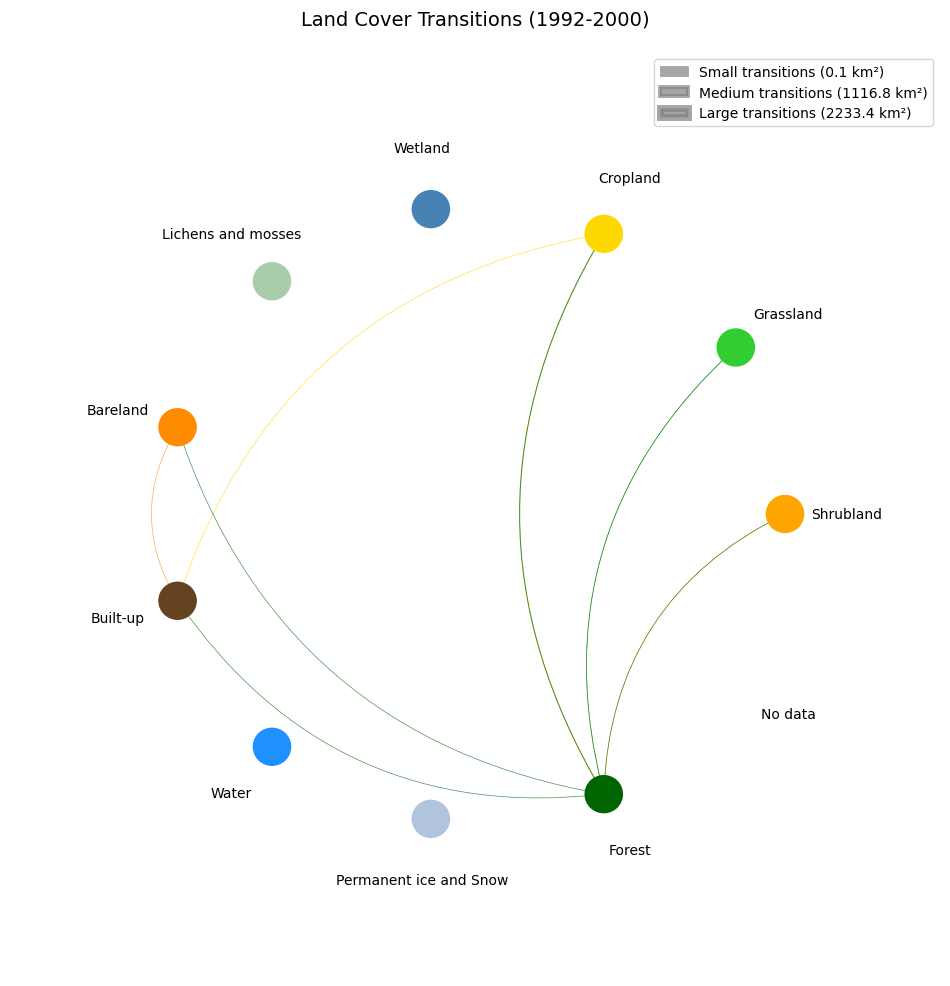

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.patches import ConnectionPatch

# Load your data
file_path = '/Users/ghulamabbaszafari/Downloads/Abbas new/Thesis_project/data/Tevre_clipped _esa_cci/lc_1992_2000/lc_transition_analysis_matrix_1992_2000.csv'
df = pd.read_csv(file_path)

# Class definitions with colors
class_info = {
    5: {'name': 'Shrubland', 'color': '#FFA500'},
    7: {'name': 'Grassland', 'color': '#32cd32'},
    8: {'name': 'Cropland', 'color': '#ffd700'},
    9: {'name': 'Wetland', 'color': '#4682b4'},
    11: {'name': 'Lichens and mosses', 'color': '#a9cda9'},
    12: {'name': 'Bareland', 'color': '#FF8C00'},
    13: {'name': 'Built-up', 'color': '#654321'},
    15: {'name': 'Water', 'color': '#1e90ff'},
    16: {'name': 'Permanent ice and Snow', 'color': '#b0c4de'},
    20: {'name': 'Forest', 'color': '#006400'},
    255: {'name': 'No data', 'color': '#ffffff'}
}

# Prepare matrix for chord diagram
def prepare_matrix(df, class_info):
    matrix = df.pivot(index='From', columns='To', values='Area_km2').fillna(0)
    all_classes = sorted(class_info.keys())
    return matrix.reindex(index=all_classes, columns=all_classes, fill_value=0)

# Create the plot
def create_chord_diagram(matrix, class_info):
    # Setup figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Create colormap
    colors = [class_info[code]['color'] for code in sorted(class_info.keys())]
    
    # Normalize values for line width
    max_val = matrix.max().max()
    min_val = matrix[matrix > 0].min().min() if (matrix > 0).any().any() else 1
    norm_val = lambda x: 0.5 + 4.5 * (x - min_val) / (max_val - min_val)
    
    # Plot nodes first
    node_positions = {}
    n_classes = len(class_info)
    radius = 5
    for i, code in enumerate(matrix.index):
        angle = 2 * np.pi * i / n_classes
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        node_positions[code] = (x, y)
        circle = plt.Circle((x, y), 0.3, color=class_info[code]['color'], zorder=3)
        ax.add_patch(circle)
        plt.text(x * 1.2, y * 1.2, class_info[code]['name'], 
                ha='center', va='center', fontsize=10)
    
    # Plot connections
    for i, from_class in enumerate(matrix.index):
        for j, to_class in enumerate(matrix.columns):
            value = matrix.at[from_class, to_class]
            if value > 0:
                x1, y1 = node_positions[from_class]
                x2, y2 = node_positions[to_class]
                
                # Create curved connection
                con = ConnectionPatch(
                    xyA=(x1, y1), 
                    xyB=(x2, y2),
                    coordsA="data", 
                    coordsB="data",
                    arrowstyle="-|>", 
                    mutation_scale=20,
                    lw=norm_val(value),
                    color=class_info[from_class]['color'],
                    alpha=0.7,
                    connectionstyle=f"arc3,rad={0.3 if i < j else -0.3}"
                )
                ax.add_patch(con)
    
    # Set limits
    ax.set_xlim(-radius*1.5, radius*1.5)
    ax.set_ylim(-radius*1.5, radius*1.5)
    ax.axis('off')
    
    # Add title
    plt.title('Land Cover Transitions (1992-2000)', pad=20, fontsize=14)
    
    # Add legend for line widths
    legend_patches = [
        mpatches.Patch(color='gray', alpha=0.7, 
                      linewidth=norm_val(min_val), 
                      label=f'Small transitions ({min_val:.1f} km²)'),
        mpatches.Patch(color='gray', alpha=0.7, 
                      linewidth=norm_val((max_val+min_val)/2), 
                      label=f'Medium transitions ({(max_val+min_val)/2:.1f} km²)'),
        mpatches.Patch(color='gray', alpha=0.7, 
                      linewidth=norm_val(max_val), 
                      label=f'Large transitions ({max_val:.1f} km²)')
    ]
    plt.legend(handles=legend_patches, loc='upper right', fontsize=10)
    
    # Save high-quality version
    plt.savefig('land_cover_transitions.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# Prepare data and create plot
matrix = prepare_matrix(df, class_info)
create_chord_diagram(matrix, class_info)
